<a href="https://colab.research.google.com/github/rizqyjoe/Facial_Expression_Recognition_CNN_VGG16/blob/main/Model%205/2_67%25_Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

In [3]:
path = '/content/drive/MyDrive/Dataset/fer2013 dataset/'
os.listdir(path)

['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv',
 'dataset',
 '.ipynb_checkpoints',
 'fer2013']

In [4]:
data = pd.read_csv(path+'icml_face_data.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Functions

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [7]:
#Overview
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

Prepare Data

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [9]:
#Define training, validation and test data:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [10]:
#Reshape and scale the images:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [11]:
#Encoding of the target value:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

Plot Emotions

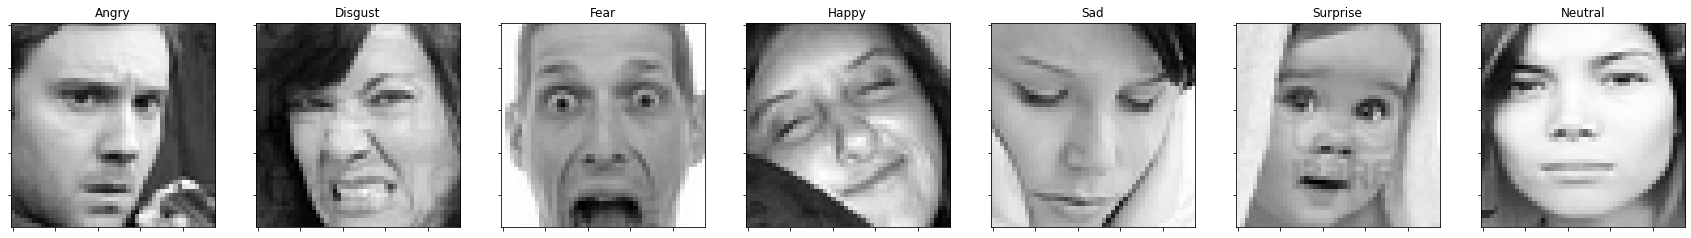

In [12]:
plot_all_emotions()

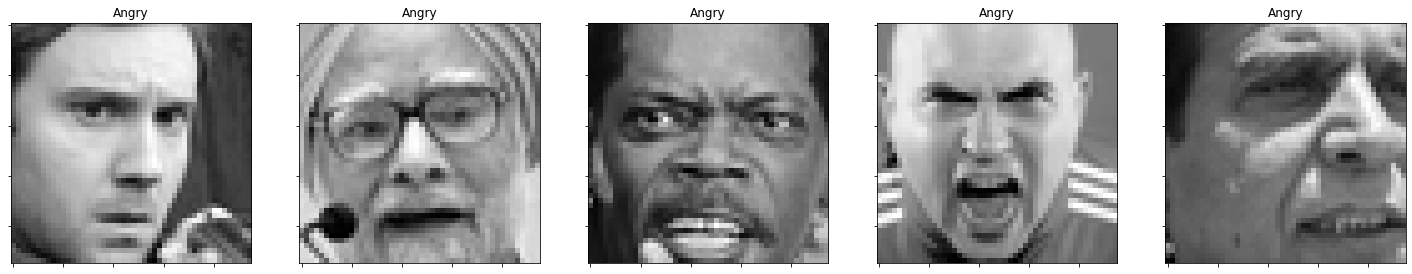

In [13]:
plot_examples(label=0)

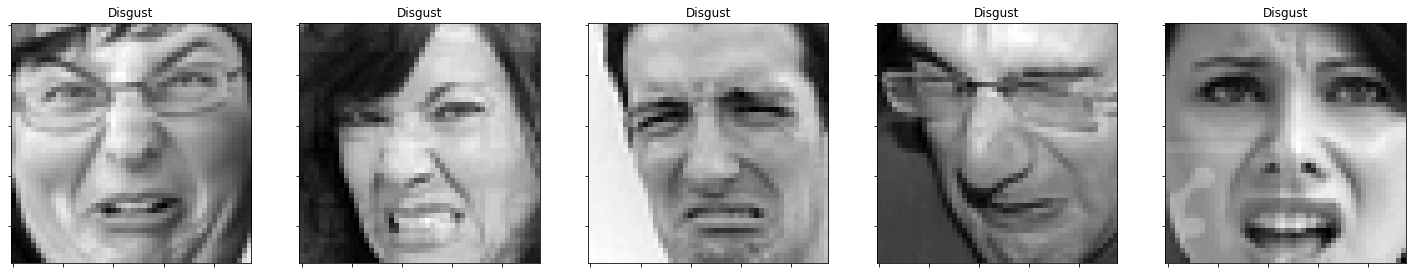

In [14]:
plot_examples(label=1)

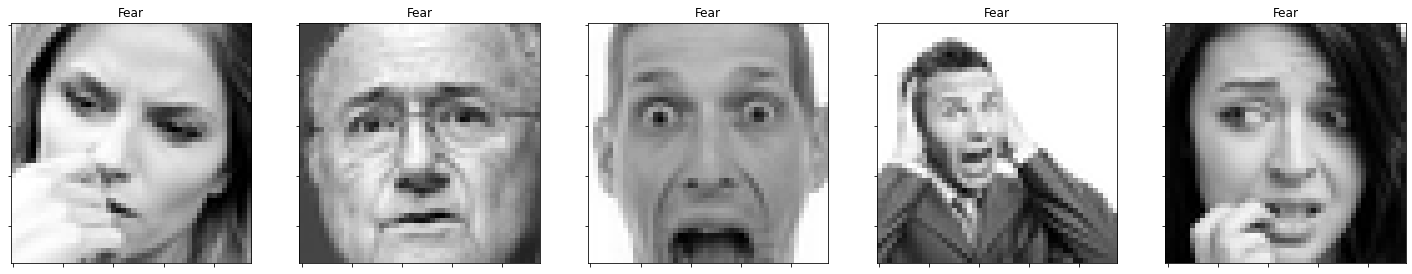

In [15]:
plot_examples(label=2)

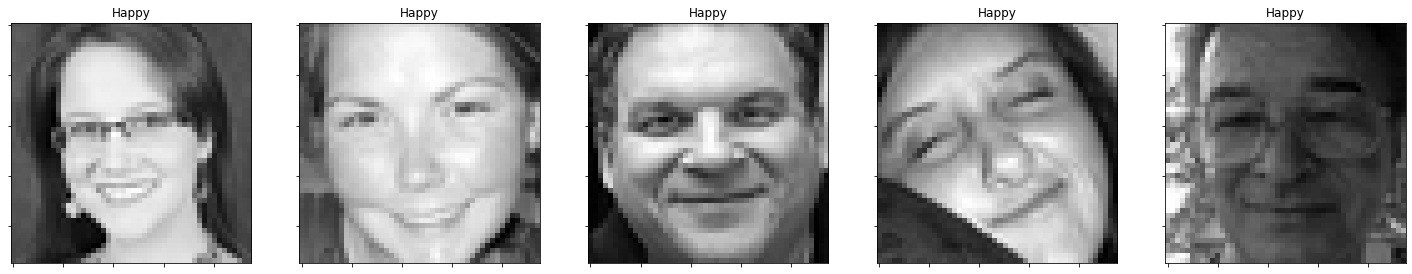

In [16]:
plot_examples(label=3)

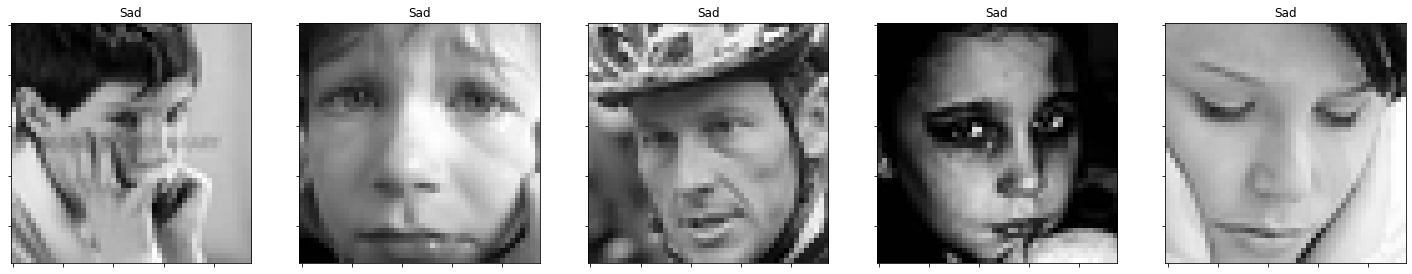

In [17]:
plot_examples(label=4)

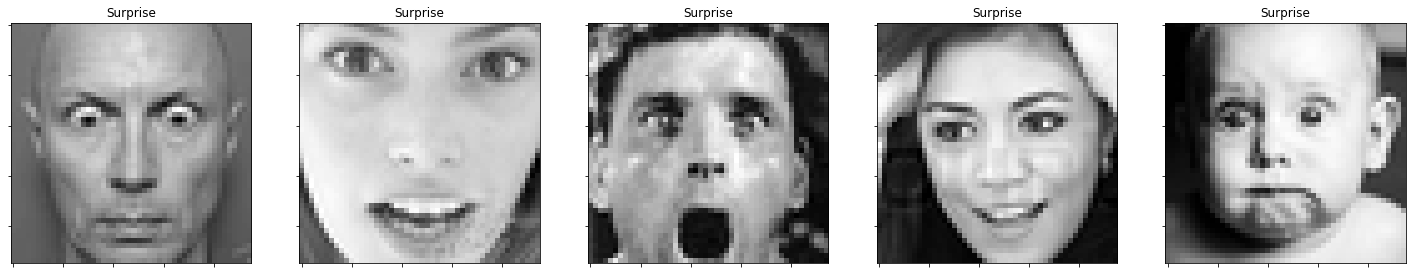

In [18]:
plot_examples(label=5)

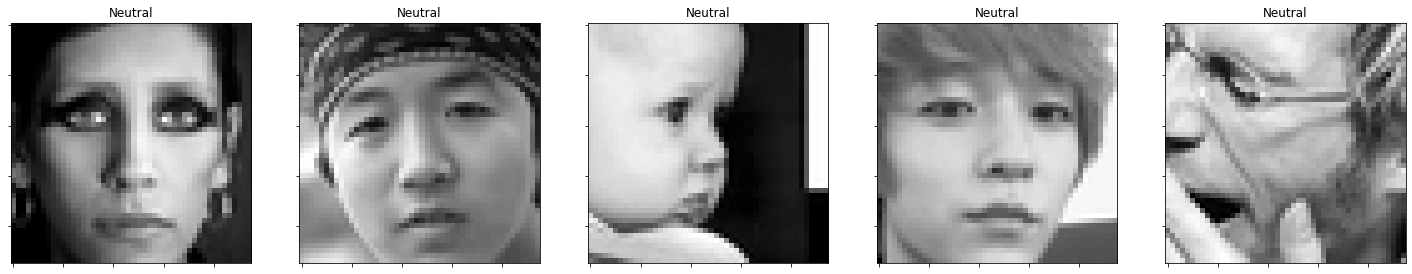

In [19]:
plot_examples(label=6)

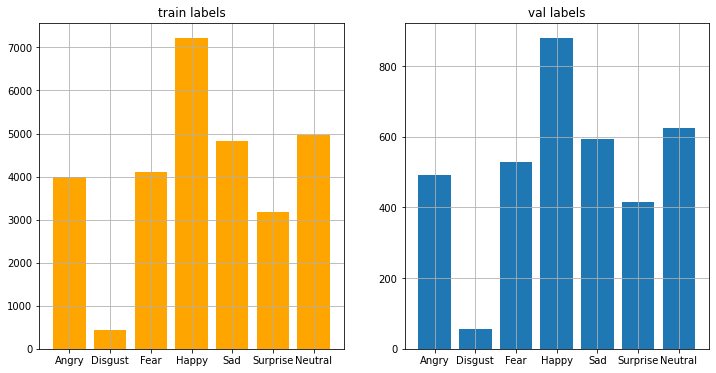

In [20]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [21]:
#Class Weights
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [22]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

Model

In [30]:
#from keras.engine import  Model
#from keras.layers import Flatten, Dense, Input
#from keras.applications.vgg16 import VGG16

model=models.Sequential()

model.add(Conv2D(input_shape=(48,48,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation = "softmax"))


#input_model = VGG16(include_top=False, weights=None, input_shape=(48, 48, 1))
#last_layer = input_model.get_layer('block5_conv1').output
#x = Flatten(name='flatten')(last_layer)
#x = Dense(hidden_dim, activation='relu', name='fc6')(x)
#x = Dense(hidden_dim, activation='relu', name='fc7')(x)
#out = Dense(nb_class, activation='softmax', name='fc8')(x)
#model = Model(input_model.input, out)

In [31]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 12, 256)      

In [43]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 27s 60ms/step - loss: 0.1734 - accuracy: 0.5537 - val_loss: 2.0818 - val_accuracy: 0.3084
Epoch 2/12
449/449 [==============================] - 27s 61ms/step - loss: 0.1689 - accuracy: 0.5642 - val_loss: 3.5883 - val_accuracy: 0.2371
Epoch 3/12
449/449 [==============================] - 27s 60ms/step - loss: 0.1645 - accuracy: 0.5741 - val_loss: 1.8867 - val_accuracy: 0.4182
Epoch 4/12
449/449 [==============================] - 27s 60ms/step - loss: 0.1592 - accuracy: 0.5879 - val_loss: 2.8272 - val_accuracy: 0.3909
Epoch 5/12
449/449 [==============================] - 27s 60ms/step - loss: 0.1539 - accuracy: 0.5993 - val_loss: 1.7310 - val_accuracy: 0.4659
Epoch 6/12
449/449 [==============================] - 27s 60ms/step - loss: 0.1484 - accuracy: 0.6155 - val_loss: 2.4152 - val_accuracy: 0.4154
Epoch 7/12
449/449 [==============================] - 27s 60ms/step - loss: 0.1539 - accuracy: 0.5996 - val_loss: 60.2383 - val_accuracy

In [44]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 12ms/step - loss: 3.7283 - accuracy: 0.3497
test caccuracy: 0.3496795892715454


In [45]:
pred_test_labels = model.predict(test_images)

Analyse Convergence

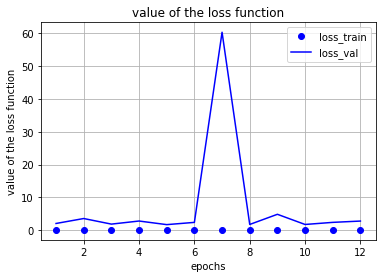

In [46]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

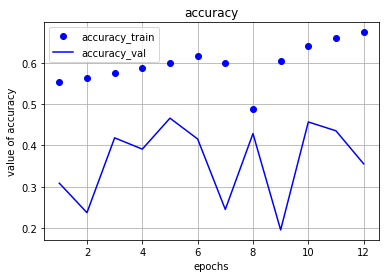

In [47]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

Analyse Result

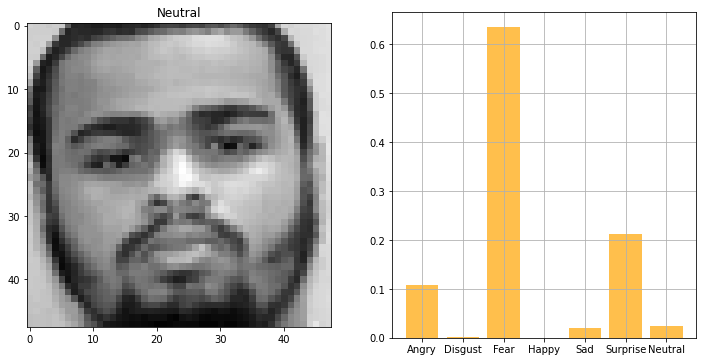

In [48]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

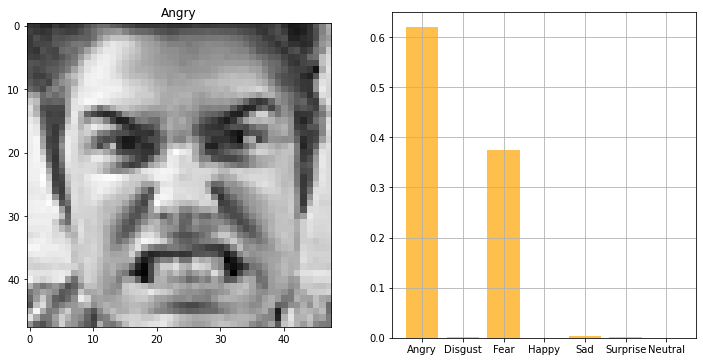

In [49]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

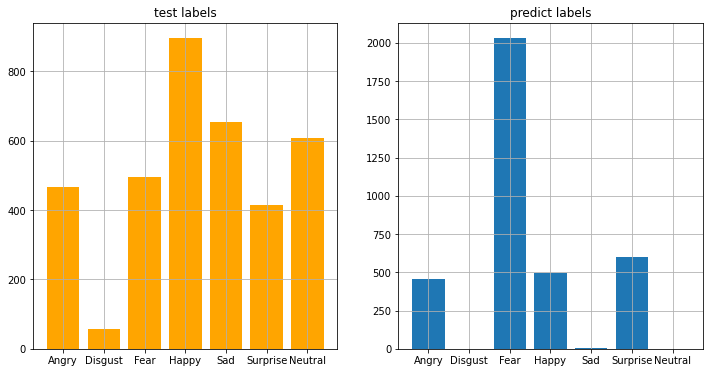

In [50]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

Analyse Wrong Prediction


In [41]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

In [42]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                classes=emotions.values(),
                                figsize=(8,8))
fig.show()

TypeError: ignored